# Pertemuan 13

- Preprocess Dataset
- Feature Extration Dataset
- Postprocessing Dataset
- Training Model
- Evaluasi Model

In [1]:
# import library 

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skew
from skimage.feature import greycomatrix, greycoprops

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

___
# 1. Preprocess Dataset Tomat

In [2]:
class Preprocessing : 
    def __init__(self, DATASET_FOLDER = "Dataset_Tomat/"):
        self.labels = []
        self.image_list = []
        self.image_range = []
        self.image_edged = []
        self.contours_list = []
        self.filtered_contours_list = []
        self.image_croped = []
        self.image_resized = []
        self.DATASET_FOLDER = DATASET_FOLDER
        
        # define range of red color in HSV
        self.lower_red = np.array([-10, 75, 50])
        self.upper_red = np.array([10, 255, 255])

        # define range of green color in HSV
        self.lower_green = np.array([35, 100, 50])
        self.upper_green = np.array([70, 255, 255])
        
        # define range of yellow color in HSV
        self.lower_yellow = np.array([10, 125, 50])
        self.upper_yellow = np.array([35, 255, 255])
        
        # define range of black color in HSV
        self.lower_black = np.array([0, 0, 0])
        self.upper_black = np.array([255, 255, 50])
        
    def ImageRead(self):
        for folder in os.listdir(self.DATASET_FOLDER):
            for file in os.listdir(self.DATASET_FOLDER + folder):
                img = cv2.imread(self.DATASET_FOLDER + folder + "/" + file)
                self.image_list.append(img)
                self.labels.append(folder) # append label (name) of image
                            
    def RangeTresholding(self):
        for img in self.image_list :          
            # convert to hsv
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            # apply range thresholding
            mask_green = cv2.inRange(hsv.copy(), self.lower_green, self.upper_green)
            mask_red = cv2.inRange(hsv.copy(), self.lower_red, self.upper_red)
            mask_yellow = cv2.inRange(hsv.copy(), self.lower_yellow, self.upper_yellow)
            mask_black = cv2.inRange(hsv.copy(), self.lower_black, self.upper_black)

            mask = mask_green + mask_red + mask_yellow + mask_black 
            res = cv2.bitwise_and(img, img, mask= mask)
            self.image_range.append(res)
            
    def EdgeDetection(self):
        for img in self.image_range :
            edged = cv2.Canny(img, 200, 210)
            self.image_edged.append(edged)
            
    def FindContour(self):
        for img in self.image_edged:
            # find contour
            contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            self.contours_list.append(contours)
        
    def FilterContour(self, min_area=50, min_w=10, min_h=10):
        for contours in self.contours_list:
            filtered_contours = []
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                area = w*h
                if not (area < min_area or w < min_w or h < min_h) :
                    filtered_contours.append(cnt)
            self.filtered_contours_list.append(filtered_contours)

    def CropByContour(self):
        for i in range(len(self.image_range)): # crop all removed background image by contour 
            img = self.image_range[i]
            cnt = np.concatenate(self.filtered_contours_list[i], axis=0) # concate all remaining contour each image
            x, y, w, h = cv2.boundingRect(cnt)
            roi = img[y:y+h, x:x+w]
            self.image_croped.append(roi)
                
    def Resize(self, size=(172,172)):
        for img in self.image_croped:
            resized = cv2.resize(img, (size[0], size[1]))
            self.image_resized.append(resized)
            
    def SaveAllImage(self, RESIZED_FOLDER = "resized_tomato/"):
        if not os.path.exists(RESIZED_FOLDER) :
            os.mkdir(RESIZED_FOLDER)
            
        for i in range(len(self.image_resized)):

            # get image
            img = self.image_resized[i]

            if img is None :
                continue
                
            # check if folder exist. if not, create that folder    
            folder_path = RESIZED_FOLDER + self.labels[i] + "/"
            if not os.path.exists(folder_path) :
                os.mkdir(folder_path)

            # save image
            file_name = self.labels[i] + "_%03d.jpg" % i
            file_path = RESIZED_FOLDER + self.labels[i] + "/" + file_name

            cv2.imwrite(file_path, img)

In [3]:
Prepro = Preprocessing()

In [4]:
Prepro.ImageRead()
Prepro.RangeTresholding()
Prepro.EdgeDetection()
Prepro.FindContour()
Prepro.FilterContour()

In [5]:
Prepro.CropByContour()
Prepro.Resize()

In [6]:
Prepro.SaveAllImage()

___
# 2. Feature Extration Dataset Tomat

In [7]:
class FeatureExtraction : 
    def __init__(self, PREPROCESSED_DATASET_FOLDER = "resized_tomato/"):
        self.labels = []
        self.image_list = []
        self.statistical_features = []
        self.glcm_matrix_list = []
        self.color_ch = ['b', 'g', 'r']
        self.glcm_feature_list = []
        self.texture_feature_labels = ['correlation', 'homogeneity', 'contrast', 'energy']
        self.PREPROCESSED_DATASET_FOLDER = PREPROCESSED_DATASET_FOLDER
        
    def ImageRead(self):
        for folder in os.listdir(self.PREPROCESSED_DATASET_FOLDER):
            for file in os.listdir(self.PREPROCESSED_DATASET_FOLDER + folder):
                img = cv2.imread(self.PREPROCESSED_DATASET_FOLDER + folder + "/" + file)
                self.image_list.append(img)
                self.labels.append(folder) # append label (name) of image
                
    def CalcStatisticalFeature(self):
        for img  in self.image_list:
            feature_ch = {}
            for i in range(len(self.color_ch)):
                feature_ch[self.color_ch[i]] = {
                    'mean' : img[:,:,i].mean(),
                    'std' : img[:,:,i].std(),
                    'skewness' : skew(img[:,:,i].reshape(-1))
                }
            
            self.statistical_features.append(feature_ch)
            
    def CalcGLCMMatrix(self):
        for img in self.image_list:
            matrix_ch = {}
            for i in range(len(self.color_ch)):
                # grab r, g, b channel
                img_ch = img[:,:,i]

                # calculate GLCM 
                glcm_img = greycomatrix(img_ch, 
                                    distances=[1],  # distance 1 pixel
                                    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],  # angel 0, 45, 90, 135 degre
                                    levels=256, # number of grey-levels counted in 8 bit grayscale image
                                    symmetric=True, 
                                    normed=True)

                matrix_ch[self.color_ch[i]] = glcm_img
            self.glcm_matrix_list.append(matrix_ch)
            
    def CalcGLCMTextureFeature(self):
        for glcm_matrix in self.glcm_matrix_list:
            feature_ch = {}
            for ch in self.color_ch:
                feature_item = {}
                for feature in self.texture_feature_labels:
                    out = greycoprops(glcm_matrix[ch], feature)[0]
                    feature_item[feature] = out
                feature_ch[ch] = feature_item
            self.glcm_feature_list.append(feature_ch)

In [8]:
Feature = FeatureExtraction()

In [9]:
Feature.ImageRead()
Feature.CalcStatisticalFeature()

In [10]:
Feature.CalcGLCMMatrix()
Feature.CalcGLCMTextureFeature()

___
# 3. Postprocssing Data

## 3.1 Transform Statistical feature & GLCM Feature to 2D Matrix as Input data (X) 

In [11]:
# Processed Statistical Feature

Feature.statistical_features

[{'b': {'mean': 35.86462276906436,
   'std': 37.520868005740596,
   'skewness': 1.1990091097863402},
  'g': {'mean': 48.12645348837209,
   'std': 41.84198879129291,
   'skewness': 0.6123098043781386},
  'r': {'mean': 120.27988101676581,
   'std': 80.52399222759165,
   'skewness': -0.5613170974303893}},
 {'b': {'mean': 35.69307733910222,
   'std': 37.60330333254923,
   'skewness': 1.218907422768485},
  'g': {'mean': 47.84383450513791,
   'std': 41.85115792665369,
   'skewness': 0.6273454317181133},
  'r': {'mean': 119.78528934559222,
   'std': 80.77816384972182,
   'skewness': -0.5462462477533083}},
 {'b': {'mean': 35.479245538128716,
   'std': 37.51195917865464,
   'skewness': 1.2086746737412886},
  'g': {'mean': 47.67343834505138,
   'std': 41.88070492924947,
   'skewness': 0.6242113809055289},
  'r': {'mean': 119.36286506219578,
   'std': 80.87783773327605,
   'skewness': -0.5392093343160346}},
 {'b': {'mean': 35.5230530016225,
   'std': 37.41469487838318,
   'skewness': 1.2085864592

In [12]:
# Processed GLCM Feature

Feature.glcm_feature_list

[{'b': {'correlation': array([0.84845066, 0.77073897, 0.81482714, 0.77962006]),
   'homogeneity': array([0.41645422, 0.36530141, 0.40668025, 0.36681374]),
   'contrast': array([426.58958928, 645.30730823, 521.37726098, 620.30946274]),
   'energy': array([0.20229169, 0.18910107, 0.19885685, 0.18868406])},
  'g': {'correlation': array([0.86645253, 0.79696771, 0.83671853, 0.80320174]),
   'homogeneity': array([0.41841009, 0.36928325, 0.40638386, 0.37696554]),
   'contrast': array([466.67754658, 707.96795595, 570.5501496 , 686.23005369]),
   'energy': array([0.19283704, 0.18178549, 0.18931931, 0.18194472])},
  'r': {'correlation': array([0.95375729, 0.92403428, 0.94332624, 0.92668376]),
   'homogeneity': array([0.3972853 , 0.33954028, 0.37485746, 0.34928738]),
   'contrast': array([596.25571195, 972.94476933, 730.17343261, 939.01097774]),
   'energy': array([0.16120756, 0.15322621, 0.16035157, 0.15303633])}},
 {'b': {'correlation': array([0.84625307, 0.78765476, 0.82132462, 0.75860141]),
 

In [13]:
# transform Statistical Feature from List of Dictionary object to 2D matrix

x1 = []
for channel in Feature.statistical_features : 
    sample = []
    for feature in list(channel.values()) :
        data = list(feature.values())
        sample.extend(data)
    x1.append(sample)
x1

[[35.86462276906436,
  37.520868005740596,
  1.1990091097863402,
  48.12645348837209,
  41.84198879129291,
  0.6123098043781386,
  120.27988101676581,
  80.52399222759165,
  -0.5613170974303893],
 [35.69307733910222,
  37.60330333254923,
  1.218907422768485,
  47.84383450513791,
  41.85115792665369,
  0.6273454317181133,
  119.78528934559222,
  80.77816384972182,
  -0.5462462477533083],
 [35.479245538128716,
  37.51195917865464,
  1.2086746737412886,
  47.67343834505138,
  41.88070492924947,
  0.6242113809055289,
  119.36286506219578,
  80.87783773327605,
  -0.5392093343160346],
 [35.5230530016225,
  37.41469487838318,
  1.2085864592476612,
  47.715589507842076,
  41.81922426252203,
  0.6224766895109648,
  119.4189764737696,
  80.79402083665943,
  -0.5415374371565256],
 [35.425601676581934,
  37.481432328266024,
  1.2123691057124406,
  47.583355868036776,
  41.84334050745135,
  0.6274492177948208,
  119.13284207679827,
  80.86990658159829,
  -0.5340990232651611],
 [36.05577339102217,
 

In [14]:
# transform GLCM Feature from List of Dictionary object to 2D matrix

x2 = []
for channel in Feature.glcm_feature_list: 
    sample = []
    for features in list(channel.values()):
        item_feature = []
        for item in list(features.values()) :
            item_feature.extend(item)
        sample.extend(item_feature)
    x2.append(sample)
x2

[[0.8484506617313328,
  0.7707389684106444,
  0.8148271371370798,
  0.7796200577329788,
  0.41645422143395305,
  0.3653014077318875,
  0.4066802533236122,
  0.36681373996225203,
  426.58958928328576,
  645.3073082315918,
  521.3772609819123,
  620.3094627406721,
  0.2022916886986314,
  0.18910107224050407,
  0.1988568536075577,
  0.18868406080616776,
  0.8664525257183796,
  0.7969677092088414,
  0.8367185310525478,
  0.8032017429046362,
  0.41841009011724806,
  0.36928325068954265,
  0.4063838560377908,
  0.3769655390289584,
  466.6775465796271,
  707.967955952259,
  570.5501495988029,
  686.230053691735,
  0.19283704293423024,
  0.1817854920212148,
  0.1893193104014631,
  0.18194471906051085,
  0.9537572881706329,
  0.924034275661764,
  0.9433262417646471,
  0.9266837632166998,
  0.3972852965030998,
  0.3395402810708357,
  0.37485746182187096,
  0.34928738129161335,
  596.2557119543046,
  972.9447693307344,
  730.1734326125394,
  939.0109777367396,
  0.16120755641816817,
  0.153226211

In [15]:
# convert to numpy array

x1_arr = np.array(x1).astype(np.float32)
x2_arr = np.array(x2).astype(np.float32)

In [16]:
x1_arr.shape

(200, 9)

In [17]:
x2_arr.shape

(200, 48)

In [18]:
# concate x1 with x2


X = np.concatenate((x1_arr, x2_arr), axis=1)

## 3.2 Transform labels of dataset (Good , Defect) to y data as Numerical Representation (0, 1)

- Label Encoding
    - find numeric representation for label / target (categorical) data
    - unsing `LabelEncoder()` from `scikit-learn`

In [19]:
Feature.labels

['Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',
 'Defect',

In [20]:
le = LabelEncoder()

le.fit(Feature.labels)

labels_name = le.classes_
print(labels_name)

['Defect' 'Good']


In [21]:
labels_vec = le.transform(Feature.labels)

In [23]:
y = np.array(labels_vec).astype(np.float32)

y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

## 3.3 Split dataset 
- split dataset for training & testing purpose
- using `train_test_split()` from `scikit-learn`

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.25, random_state=42) # allocate 25 dataset as test set

In [25]:
print(X_train.shape, y_train.shape, X_test.shape,  y_test.shape)

(150, 57) (150,) (50, 57) (50,)


___
## 3.4 Wrap Postprocessing into class

In [26]:
class Postprocessing :
    def __init__ (self, statistical_features, glcm_feature_list, labels):
        self.X = []
        self.y = []
        self.X_train = []
        self.X_test = [] 
        self.y_train = []
        self.y_test = []
        self.statistical_features = statistical_features
        self.glcm_feature_list = glcm_feature_list
        self.labels = labels
        self.labels_name = []
        self.test_size = 0.25
        
        
    def transformX(self):
        # transform statistical feature to 2D matrix
        x1 = []
        for channel in self.statistical_features : 
            sample = []
            for feature in list(channel.values()) :
                data = list(feature.values())
                sample.extend(data)
            x1.append(sample)

        # transform GLCM feature to 2D matrix
        x2 = []
        for channel in self.glcm_feature_list: 
            sample = []
            for features in list(channel.values()):
                item_feature = []
                for item in list(features.values()) :
                    item_feature.extend(item)
                sample.extend(item_feature)
            x2.append(sample)
            
        # concate 2d Matrix
        x1 = np.array(x1).astype(np.float32)
        x2 = np.array(x2).astype(np.float32)
        self.X = np.concatenate((x1, x2), axis=1)
        print("X size :\n", X.shape)
        
    def transformY(self):
        le = LabelEncoder()
        le.fit(self.labels)
        self.labels_name = le.classes_
        print("labels_name :\n", self.labels_name)
        
        labels_vec = le.transform(self.labels)
        self.y = np.array(labels_vec).astype(np.float32)
        print("y size :\n", y.shape)
        
    def splitData(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                                    self.X, self.y, test_size=self.test_size, random_state=42)
        print("Split size :\n", self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)

In [27]:
Postpro = Postprocessing(Feature.statistical_features, 
                         Feature.glcm_feature_list, 
                         Feature.labels)

Postpro.transformX()
Postpro.transformY()
Postpro.splitData()

X size :
 (200, 57)
labels_name :
 ['Defect' 'Good']
y size :
 (200,)
Split size :
 (150, 57) (50, 57) (150,) (50,)


___
# 4. Training Model Klasifikasi Tomat

In [28]:
input_dim = Postpro.X_train.shape[1]

In [29]:
mlp = cv2.ml.ANN_MLP_create()

network_layer = np.array([input_dim, 128, 64, 32, 1]).astype(np.uint8)
mlp.setLayerSizes(network_layer)

mlp.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM)
mlp.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)

In [30]:
# set term criteria : maximum 100 iteration or stop when achieve 90% accuracy

mlp.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 0.9))

- method `.setTermCriteria((criteria_type, maxCount, epsilon))`:
    - where `criteria_type` :
        - `cv2.TERM_CRITERIA_MAX_ITER` : the maximum number of iterations or elements to compute
        - `cv2.TERM_CRITERIA_EPS` : the desired accuracy or change in parameters at which the iterative algorithm stops
        - `cv2.TERM_CRITERIA_MAX_ITER` + `cv2.TERM_CRITERIA_EPS`
        - `maxCount` and `epsilon` is termination value for each selected createria by `criteria_type` 

- Train MLP

In [31]:
mlp.train(Postpro.X_train,
          cv2.ml.ROW_SAMPLE,
          Postpro.y_train)

True

- save model

In [32]:
mlp.save("klasifikasi_tomat_mlp_model.xml")

- load model

In [33]:
mlp.load("klasifikasi_tomat_mlp_model.xml")

<ml_ANN_MLP 000001F80077B9F0>

- Predict Data

In [34]:
y_pred = mlp.predict(Postpro.X_test)[1].round().reshape(-1)

# 5. Model Evaluation

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 6))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

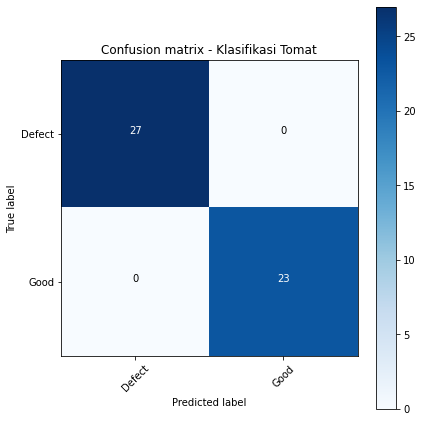

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(labels_vec))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels_name,normalize=False,
                      title='Confusion matrix - Klasifikasi Tomat')

- Evaluation Report Summary (per-class)
    - Precision
    - Recall
    - f1-score
    - accuracy

In [37]:
print(classification_report(y_test, 
                            y_pred, 
                            target_names=labels_name))

              precision    recall  f1-score   support

      Defect       1.00      1.00      1.00        27
        Good       1.00      1.00      1.00        23

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



___
# Task
- Buat Class `TrainingMLP()` yang didalamnya memiliki beberapa method
    - method `train()` :
        - membuat mlp object, set netwok layer, activation, training method & training criteria
        - Training model
        - Save Model
    - method `evaluate()` :
        - Load Model
        - Predict Model
        - Plot Confussion Matrix
        - Print Classification Report